In [1]:
import numpy as np
import process_data
process_data = reload(process_data)
folder = '../annotations/coupa/video2/'
fname = folder + 'annotations.txt'
x_raw,y_raw = process_data.get_trajectories(fname,label="Biker")
x_smooth, u_smooth, y_smooth , v_smooth = process_data.smooth_trajectories(x_raw,y_raw)

In [2]:
from PIL import Image
fname = folder + 'reference.jpg'
im = Image.open(fname)
width,height = im.size
target_points = [ (-1,-1) , (-1,1), (1,1) ]
reference_points = [(0,0) , (0,height) , (width,height)]
x_smooth = np.array( map( lambda x: 2*x/width-1 , x_smooth ) )
u_smooth = np.array( map( lambda x: 2*x/width , u_smooth ) )
y_smooth = np.array( map( lambda x: -2*x/height-1 , y_smooth ) )
v_smooth = np.array( map( lambda x: -2*x/height , v_smooth ) )

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

(-1.0, 1.0, -1.0, 1.0)

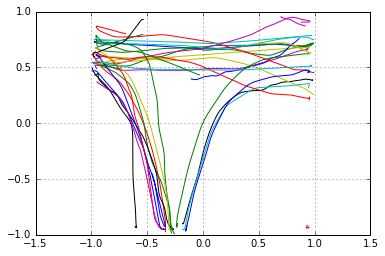

In [4]:
for k in range(len(x_smooth)):
    plt.plot(x_smooth[k],y_smooth[k])
plt.grid()
plt.axis('equal')

[0, 1, 0, 1]

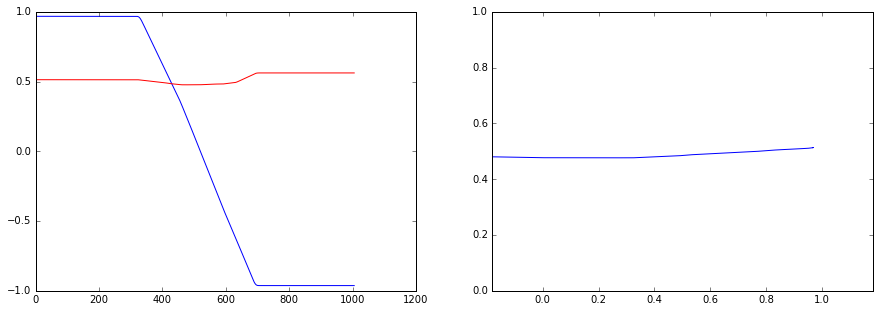

In [5]:
k = 24
fig, ax_arr = plt.subplots( 1,2 ,figsize=(15,5))
ax_arr[0].plot(x_smooth[k],'b-')
ax_arr[0].plot(y_smooth[k],'r-')
ax_arr[1].plot(x_smooth[k],y_smooth[k])
ax_arr[1].axis('equal')
ax_arr[1].axis([0,1,0,1])

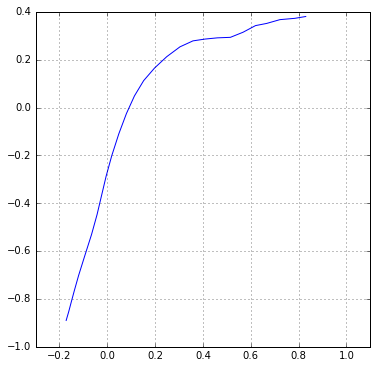

In [6]:
plt.figure(figsize=(6,6))
#plt.plot(x_smooth[0][460:800:10],y_smooth[0][460:800:10])
plt.plot(x_smooth[6][270:550:10],y_smooth[6][270:550:10])
#plt.plot(x_smooth[14][400:580:10],y_smooth[14][400:580:10])
plt.axis('equal')
plt.grid()

## Cost function
For any two points $x_0,x_T$ we let $x(t;\theta)$ denote the curve on $[0,T]$ which minimizes the action
$$
    S[x;\theta] := \int_0^T L_\theta( x,\dot{x}) dt
$$
In otherwords, $x( \cdot \,;\theta) = {\rm argmin}_y( S[y;\theta] ) $.
Our goal is to learn the parameters, $\theta$.
Given a single curve $X:[0,T]\to D$, the cost function for our learning algorithm will be
$$
    C(\theta) = \frac{1}{2} \int_0^T \| X(t) - x(t;X_0,X_T,\theta) \|^2 dt
$$
so that the gradient is
$$
    dC(\theta) = - \int \langle X(t) - x(t;\theta) , \delta_\theta x(t;\theta) \rangle dt
$$
where $\delta_\theta x(t;\theta)$ solves the boundary value problem
$$
    \ddot{x} = - \nabla V(x;\theta) \quad , \frac{d^2}{dt^2} \delta_\theta x = - \delta_\theta \nabla V(x;\theta) \delta_\theta x
$$
with the boundary conditions $x(0),x(T)$ given and $\delta_\theta x(0) = \delta_\theta x(T) = 0$.

##Collocation method
Let's solve the nonlinear optimization problem:
Minimize
$$
    C(\theta,q) = \sum_{t = 0}^{N} \| q_{\rm obs}(t) - q(t) \|^2
$$
subject to the constraint $q(0) = q_{\rm obs}(0),q(N) = q_{\rm obs}(N)$ fixed and
$$
    \frac{q(i-1) - 2 q(i) + q(i+1)}{2} + \nabla V_\theta( q(i) ) = 0.
$$
for $i=1,\dots,N-1$

## Training in a Hermite Polynomial Basis
In this section we consider potential functions of the form
$$
    V(x,y) = \sum_{k_1,k_2=0}^{K} \theta[k_1,k_2] H_{k_1}(x) H_{k_2}(y)
$$
where $H_k$ is the $k$th Hermite polynomial.
The gradients of $V$ is given by
$$
    \partial_x V(x,y) = 2 \sum_{k_1,k_2}^K \theta[k_1,k_2] k_1 H_{k_1-1}(x) H_{k_2}(y) \\
    \partial_y V(x,y) = 2 \sum_{k_1,k_2}^K \theta[k_1,k_2] k_2 H_{k_1}(x) H_{k_2-1}(y) \\
$$

In [7]:
curves = [ np.vstack([x_smooth[0][460:800:10], y_smooth[0][460:800:10]]) ]
curves.append( np.vstack( [ x_smooth[4][230:510:10],y_smooth[4][230:510:10] ] ) )
curves.append( np.vstack( [ x_smooth[6][290:580:10],y_smooth[6][290:580:10] ] ) )
curves.append( np.vstack( [ x_smooth[13][170:300:10],y_smooth[13][170:300:10] ] ) )
curves.append( np.vstack( [ x_smooth[14][420:580:10], y_smooth[14][420:580:10] ] ) )
curves.append( np.vstack( [ x_smooth[15][50:200:10],y_smooth[15][50:200:10] ] ) )
curves.append( np.vstack( [ x_smooth[17][400:680:10],y_smooth[17][400:680:10] ] ) )
curves.append( np.vstack( [ x_smooth[20][200:400:10],y_smooth[20][200:400:10] ] ) )
curves.append( np.vstack( [ x_smooth[22][370:650:10],y_smooth[22][370:650:10] ] ) )
curves.append( np.vstack( [ x_smooth[24][350:650:10],y_smooth[24][350:650:10] ] ) )

In [8]:
def get_xy_theta(decision_variables, curves , k_max ):
    x_list = []
    y_list = []
    ref = 0
    for curve in curves:
        n = curve.shape[1] #number of collocation points
        x_list.append( decision_variables[ref:ref+n] )
        y_list.append( decision_variables[ref+n:ref+2*n] )
        ref += 2*n
    theta = decision_variables[ ref:].reshape( (k_max+1,k_max+1) )
    return x_list,y_list,theta

def cost_function(decision_variables, curves , k_max ):
    x_list,y_list,theta = get_xy_theta( decision_variables , curves , k_max)
    out = 0.
    for x,y,c in zip( x_list, y_list, curves):
        out += np.dot(x-c[0],x-c[0]) + np.dot(y-c[1],y-c[1])
    return out

def EL_constraint(decision_variables , curves, k_max ):
    from scipy import sparse
    x_list,y_list,theta = get_xy_theta( decision_variables , curves , k_max)
    out_list = []
    k = np.arange(-k_max , k_max+1)
    for x,y in zip(x_list,y_list):
        n = x.size
        A_matrix = sparse.diags([np.ones(n-2),-2*np.ones(n-1),np.ones(n-2)],
                            offsets=[0,1,2], shape=(n-2,n) )
        a_x = A_matrix.dot( x)
        a_y = A_matrix.dot( y)
        from numpy.polynomial.hermite import hermder, hermval2d
        theta_x = hermder( theta, m=1, axis=0 )
        theta_y = hermder( theta, m=1, axis=1 )
        V_x = hermval2d( x[1:n-1], y[1:n-1], theta_x )
        V_y = hermval2d( x[1:n-1], y[1:n-1], theta_y )
        out_list += [a_x+V_x, a_y+V_y]
    return np.hstack( out_list )

def boundary_constraint(decision_variables , curves , k_max):
    x_list,y_list,_ = get_xy_theta( decision_variables, curves, k_max)
    n_curves = len(curves)
    out = np.zeros( (4,n_curves) )
    for k,(x,y) in enumerate( zip(x_list,y_list) ):
        out[0][k] = curves[k][0,0] - x[0]
        out[1][k] = curves[k][0,-1] - x[-1]
        out[2][k] = curves[k][1,0] - y[0]
        out[3][k] = curves[k][1,-1] - y[-1]
    return out.flatten()

k_max = 4
constraint_list = []
constraint_list.append({'type':'eq', 'fun':EL_constraint, 'args':(curves,k_max)} )
constraint_list.append({'type':'eq', 'fun':boundary_constraint, 'args':(curves,k_max) } )

theta = np.zeros( (k_max+1, k_max+1) )
guess_list = []
for c in curves:
    x_guess = np.linspace(c[0,0],c[0,-1], len(c[0]))
    y_guess = np.linspace(c[1,0],c[1,-1], len(c[1]))
    guess_list += [x_guess,y_guess]
initial_guess = np.hstack( guess_list + [theta.flatten(),] )

def cb_function(x):
    global k_max,curves
    print "Cost = %f" % cost_function(x, curves , k_max )
    return 0

from scipy.optimize import minimize
res = minimize( cost_function , initial_guess , constraints=constraint_list , args = (curves,k_max ),
              callback = cb_function)
print res.message
x_list,y_list,theta_opt = get_xy_theta( res.x , curves, k_max)

Cost = 7.583556
Cost = 0.489562
Cost = 0.348102
Cost = 0.367436
Cost = 0.362813
Cost = 0.345922
Cost = 0.343383
Cost = 0.338847
Cost = 0.336585
Cost = 0.336013
Cost = 0.335636
Cost = 0.335627
Cost = 0.335633
Cost = 0.335633
Cost = 0.335633
Optimization terminated successfully.


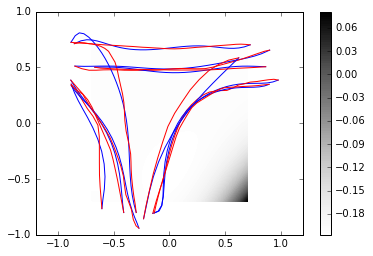

In [9]:
x_grid,y_grid = np.meshgrid( np.linspace(-0.7,0.7,50) , np.linspace(-0.7,0.7,50))
n_curves = len(curves)
from numpy.polynomial.hermite import hermval2d
V = hermval2d(x_grid, y_grid, theta_opt)
plt.contourf(x_grid,y_grid,V,100,cmap='Greys')
plt.colorbar()
for k in range(n_curves):
    plt.plot(x_list[k],y_list[k], 'b-')
    plt.plot(curves[k][0,:] , curves[k][1,:],'r-')
axis_size= plt.axis('equal')

In [10]:
np.save('theta_opt',theta_opt)

# Advection
Now that we have learned $\theta$, let's advect.  Firstly, the equations of motion are given by
$$
    \dot{x} = u \\
    \dot{y} = v \\
    \dot{u} = V_x = 2\pi i \sum_k \theta_k k_1 e^{2\pi i k_1 x + k_2 y} \\
    \dot{v} = V_y 2\pi i \sum_k \theta_k k_2 e^{2\pi i k_1 x + k_2 y}
$$
so that the Louiville equation is
$$
    \partial_t \rho + u \partial_x\rho + v \partial_y \rho + V_x \cdot \partial_u \rho + V_y \cdot \partial_v \rho = 0
$$


In [11]:
import numpy as np
theta_opt = np.load('theta_opt.npy')
print theta_opt.shape

(5, 5)


In [12]:
k_max = theta_opt.shape[0]-1
from numpy.polynomial.hermite import herm2poly
from numpy.polynomial.hermite import hermder
V_x_herm = hermder(theta_opt, m=1, axis=0)
V_y_herm = hermder(theta_opt, m=1, axis=1)

V_x_poly = np.zeros_like(V_x_herm)
V_y_poly = np.zeros_like(V_y_herm)

for k in range(k_max+1):
    V_x_poly[:,k] = herm2poly( V_x_herm[:,k] )
for k in range(k_max):
    V_x_poly[k,:] = herm2poly(V_x_poly[k,:] )

for k in range(k_max):
    V_y_poly[:,k] = herm2poly( V_y_herm[:,k] )
for k in range(k_max+1):
    V_y_poly[k,:] = herm2poly(V_y_poly[k,:] )

Making hermite series
CPU times: user 88 µs, sys: 64 µs, total: 152 µs
Wall time: 114 µs
CPU times: user 6.89 s, sys: 29.1 ms, total: 6.92 s
Wall time: 6.94 s
entering function
initialized output
(32, 32)
(32, 2500)
dealt with dimension 0
(2500,)
delta with dimension 1
(2500,)


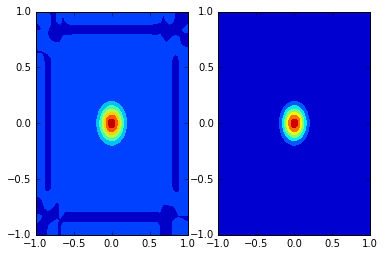

In [100]:
import hermite_function
hermite_function = reload( hermite_function )
#p_x = np.zeros( (1,1,2,1) )
#p_y = np.zeros( (1,1,1,2) )
#p_u = np.zeros( (k_max,k_max+1,1,1) )
#p_v = np.zeros( (k_max+1,k_max,1,1) )

#p_x[0,0,1,0] = 1.
#p_y[0,0,0,1] = 1.
#p_u[:,:,0,0] = V_x_poly
#p_v[:,:,0,0] = V_y_poly
#polynomials = [p_x,p_y,p_u,p_v]

M=(1.5,1.5,1,1)
deg=(20,20,5,5)

sigma = 0.3
mu_x = x_smooth[6][300]
mu_y = y_smooth[6][300]
mu_u = 0.5*( x_smooth[6][301] - x_smooth[6][299] )
mu_v = 0.5*( y_smooth[6][301] - y_smooth[6][299] )
G = lambda x,mu,s : np.exp( - (x-mu)**2 / (2*s**2) )
f = lambda x,y,u,v: G(x,mu_x,sigma)*G(y,mu_y,sigma)*G(u,mu_u,sigma)*G(v,mu_v,sigma)
print "Making hermite series"
%time h_series = hermite_function.hermite_function_series(M=M, deg=deg )
%time h_series.interpolate_function(f)

h_series_2d = hermite_function.hermite_function_series(M=[1,1],deg=[30,30])
f_2d = lambda x,y: G(x,0,0.1)*G(y,0,0.1)
h_series_2d.interpolate_function( f_2d )
x_grid,y_grid = np.meshgrid( np.linspace(-1,1,50), np.linspace(-1,1,50))
fig,ax_arr = plt.subplots(1,2)
ax_arr[0].contourf(x_grid,y_grid, h_series_2d.evaluate_on_grid([x_grid,y_grid] ) )
ax_arr[1].contourf(x_grid,y_grid, f_2d(x_grid,y_grid))
#print "Making advection operator"
#%time L_f = hermite_function.Lie_derivative( polynomials=polynomials, M=M, deg=deg )

## Visualization
We can't actually view a distribution in $\mathbb{R}^4$, so we will marginalize over the velocity variables, $u$ and $v$.  In order to integrate $u$ and $v$ we use the recursion relation
$$
    h_{n+1}(x) = \frac{x}{ \sqrt{n+1} } h_n(x) - \sqrt{ \frac{n}{n+1} } h_{n-1}(x)
$$
and the integrals
$$
    \int_{-\infty}^\infty h_0(x) dx = \frac{1}{ \pi^{1/4} \sqrt{2} } \Gamma( 1/2) \\
    \int_{-\infty}^\infty x h_1(x) dx = 2 \pi^{-1/4} \Gamma(3/2)
$$
To find
$$
    \int H_n(x) \exp( -x^2 / 2) dx = 
        \int h_n(x) dx = 4^n \sqrt{2} \, \Gamma \left( n + \frac{1}{2} \right)
$$
for $n$ even.  The integral is $0$ when $n$ is odd. (see http://math.stackexchange.com/questions/280945/integral-of-hermite-polynomial-multiplied-by-exp-x2-2)

In [101]:
x_span = np.linspace(-1,1,20)
y_span = np.linspace(-1,1,20)
u_span = np.linspace(-1,1,10)
v_span = np.linspace(-1,1,10)
grid_list = np.meshgrid(x_span,y_span,u_span,v_span)
f_grid = h_series.evaluate_on_grid(grid_list)

entering function
initialized output
(22, 22, 7, 7)
(22, 7, 7, 40000)
dealt with dimension 0
(7, 7, 40000)
delta with dimension 1
(7, 40000)
delta with dimension 2
(40000,)
delta with dimension 3
(40000,)


(20, 20)
-0.0138741835497
-0.137638499459
-0.764000008402


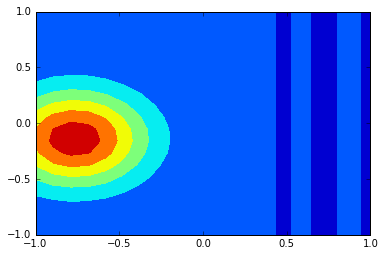

In [102]:
f_xy = f_grid.sum(axis=3).sum(axis=2)
print f_xy.shape
x_grid,y_grid = np.meshgrid(x_span,y_span)
plt.contourf(x_grid,y_grid,f_xy)
print f_xy.min()
print mu_x
print mu_y